<h1 style="color: navy bleu;text-align:center">  M2 MAS DS- Problèmes inverses et optimisation convexe 2022

<h2 style="color: navy bleu;text-align:center"> Rendu du Tp2 : Analyse multirésolution et Forward-Backward


<h3 style="color: navy bleu"> Saïda Guezoui, groupe DS </h3>

<h2 style="color: navy bleu"> I. Introduction 

Dans ce tp, nous allons utiliser l'image de Lena pour une analyse multirésolution et Forward-Backward. 

Nous allons d'abord commencer par la manipulation des ondellettes à l'aide de la fonction Wavelets de PyWavelet et calculer la décomposition multirésolution de l'image. Ensuite, nous allons découvrir les algorithmes de descente de gradient et Ista et leur application dans le cas de l'image de Lena pour enfin les comparer à l'algorithme Tikhonov vu précédemment. 
<img src="lena.png" alt="Lena" width="128" height="128"/>

Avant de commencer, nous importons les bibliothèques nécessaires pour ce tp.

In [1]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pywt

<h2 style="color: navy bleu"> II. Pré-traitement des données 

On charge les données de l'image de Lena de la même manière dans le premier tp. 

<h3 style="color: navy bleu"> A. Chargement 

In [2]:
#on charge l'image de lena à l'aide de la fonction imread de la bibliothèque image de matplotlib
y = mpimg.imread("lena.png")

#on ne garde que la première composante car niveau de gris
y = y[:,:,0];

#l'image est de type int ou float on la cast en float pour pouvoir faire des calculs
# et on la remet à l'échelle si besoin
if (y.dtype == 'float32'):
    y = y * 255
    
y = y.astype(float)

#la taille de l'image à l'aide de l'attribut shape
[n1,n2] = y.shape

# on affiche le maximum et le minimum pour vérifier que les valeurs de niveau de gris varient 
# bien entre 0 et 255 (et pas 0 et 1 par exemple)

print([y.min(), y.max()])

[25.0, 245.0]


<h3 style="color: navy bleu"> B. Affichage 

Text(0.5, 1.0, "Image originale avec d'autres couleurs")

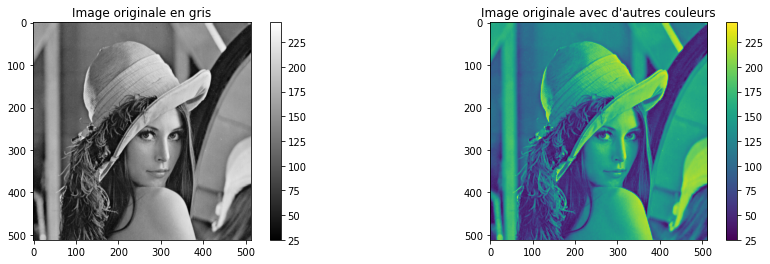

In [3]:
#on donne une taille à la figure
plt.figure(figsize =(15,4))

# colonne 1 pour la première image
plt.subplot(1,2,1)
#on l'affiche en niveau de gris
plt.imshow(y, cmap="gray")
#on affiche la palette de couleur (colorbar) associée
plt.colorbar()
#on lui donne un titre
plt.title('Image originale en gris')

# colonne 2 pour la deuxième image  
plt.subplot(1,2,2)
plt.imshow(y, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Image originale avec d'autres couleurs")

<h3 style="color: navy bleu"> C. Fonctions utiles du TP1

On récupère quelques fonctions utilisées dans le premier tp car elles nous seront utiles. 

In [4]:
def gaussian(n,s):
    x = np.concatenate((np.arange(0,n/2,1),np.arange(-n/2,0,1)))
    [Y,X] = np.meshgrid(x,x)
    h = np.exp((-X**2-Y**2)/(2*s**2))
    h = h/np.sum(h)
    return h

In [5]:
def uniform(n,s):
    h=np.zeros((n,n))
    h[0:int(np.ceil(s/2)),0:int(np.ceil(s/2))] = 1
    h[n-int(np.floor(s/2)):n,0:int(np.ceil(s/2))]=1
    h[0:int(np.ceil(s/2)),n-int(np.floor(s/2)):n]=1
    h[n-int(np.floor(s/2)):n,n-int(np.floor(s/2)):n]=1
    h = h/np.sum(h)
    return h

In [6]:
def degrad_imag(y,h,alpha,typ):
    if typ == "gaussien":
        #on floute
        z = np.real(np.fft.ifft2(np.fft.fft2(h)*np.fft.fft2(y)))
        #on bruite
        z = z+np.sqrt(alpha)*np.random.normal(size=np.shape(y))
    elif typ == "poisson":
        #on floute
        z = np.real(np.fft.ifft2(np.fft.fft2(h)*np.fft.fft2(y)))
        #on bruite
        z = np.random.poisson(alpha*z)
    return z

In [7]:
def snr(x,xref):
    s = 10*np.log10(np.mean(xref**2)/np.mean((xref-x)**2))
    return s

def psnr(x,xref):
    s = 10*np.log10(255**2/np.mean((xref-x)**2))
    return s

<h2 style="color: navy bleu"> III. Manipulation des ondelettes 

<h3 style="color: navy bleu"> A. Analyse multirésolution 2D

Afin de manipuler des ondelettes en Python, nous utiliserons la boîte à outils PyWavelets. Pour plus d'informations, on pourra se référer à la documentation de cette boîte à outils disponible à l'adresse suivante
<a href = "https://pywavelets.readthedocs.io/en/latest/">https://pywavelets.readthedocs.io/en/latest/</a>

A l'aide de la fonction Wavelets de PyWavelets, on génère tous les attributs de l'ondelette de Daubechies dont les filtres associés sont de longueur 4. Et on extrait 2 filtres $h_1$ et $h_2$:

In [8]:
wavelet = pywt.Wavelet('db2')
print(wavelet)

# Filtre h1 
h1=wavelet.dec_lo

# Filtre h2
h2=wavelet.dec_hi

Wavelet db2
  Family name:    Daubechies
  Short name:     db
  Filters length: 4
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


<h3 style="color: navy bleu"> A.1. Bancs de filtres

Dans cette partie, nous traçons les deux filtres h1 et h2. Ensuite, nous allons déterminer la réponse fréquentielle de chacun de ces filtres en effectuant une fft sur 256 points de cette réponse impulsionnelle. Enfin, nous allons représenter graphiquement le module de cette réponse fréquentielle (on prêtera attention à la graduation de l'axe des fréquences).

<h3 style="color: navy bleu"> A.1.1. Affichage des filtres 

Text(0.5, 1.0, 'Le filtre h2')

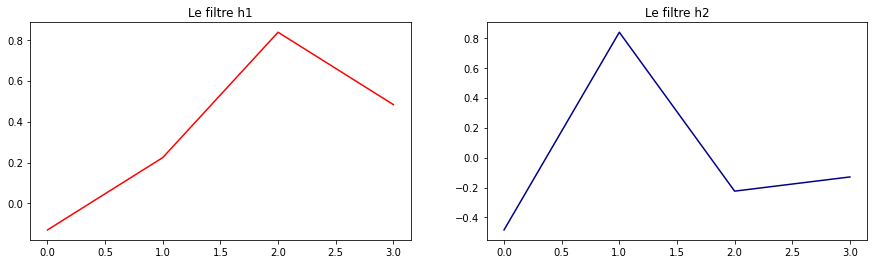

In [9]:
# Taille de la figure 
plt.figure(figsize =(15,4))

# Affichage du filtre h1  
plt.subplot(1,2,1)
plt.plot(h1, color = "red")
plt.title("Le filtre h1")

# Affichage du filtre h2
plt.subplot(1,2,2)
plt.plot(h2, color = "darkblue")
plt.title("Le filtre h2")


<h3 style="color: navy bleu"> A.1.2. Les réponses fréquentielles de chaque filtre 

In [10]:
fft_h1 = np.fft.fft(h1, 256)
fft_h2 = np.fft.fft(h2, 256)

#print("La réponse fréquencielle du filtre h1 : \n", fft_h1)
#print("\n La réponse fréquencielle du filtre h2 : \n", fft_h2)

<h3 style="color: navy bleu"> A.1.3. Représentation graphique du module des réponses fréquentielles

Text(0.5, 1.0, 'Représentation de la réponse fréquentielle de h2')

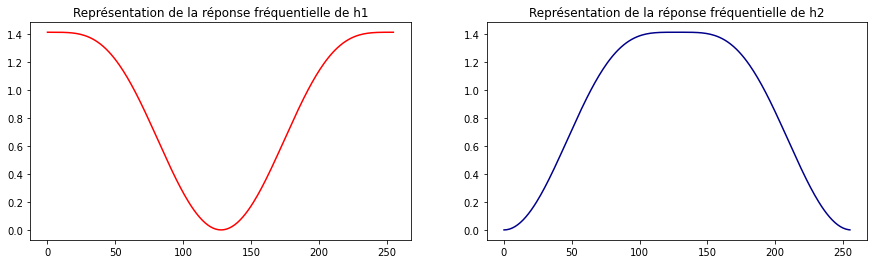

In [11]:
# Module de la réponse fréquentielle du filtre h1 
plt.figure(figsize =(15,4))
plt.subplot(1,2,1)
plt.plot(np.abs(fft_h1), color = "red")
plt.title("Représentation de la réponse fréquentielle de h1")

# Module de la réponse fréquentielle du filtre h2
plt.subplot(1,2,2)
plt.plot(np.abs(fft_h2), color = "darkblue")
plt.title("Représentation de la réponse fréquentielle de h2")

<b>Réponse:</b>

D'après la représentation graphique, on constate que le filtre passe-haut est le h2 vu qu'il permet de conserver que les fréquences hautes, contrairement à h2 qui conserve les basses fréquences. 

<h3 style="color: navy bleu"> A.2. Analyse multirésolution 2D 

Le but de cette partie est de calculer la décomposition multirésolution de l'image test Lena. <br />

Nous allons Calculer la décomposition multirésolution de l'image test Lena sur $j_m=3$ niveaux de décomposition (mêmes ondelettes qu'étudiées à la section précédente) et stocker le résultat dans la variable appelée <i>coeffs</i>. (Pour cela on utilisera la commande <i>wavedec2</i> et on s'assurera de faire des extensions périodiques (mode='periodization')).  <br />

Pour visualiser les coefficients obtenus et observer les sous-bandes obtenues, nous allons procéder ainsi :
<ul>
<li> Pour visualiser tous les coefficients d'un coup, on utilise la commande <i>coeffs_to_array</i> qui range les coefficients de décomposition dans un tableau. (On pourra utiliser les options vmin et vmax de imshow pour mieux voir le contenu de ce tableau). </li> 
<li>Pour visualiser chaque sous-bande, on extrait d'abord chaque sous-bande 
<br>
<i>cA3, (cH3, cV3, cD3),(cH2, cV2, cD2),(cH1, cV1, cD1) = coeffs</i>
<br>
et on visualise chaque sous-bande de coefficients indépendamment.</li> 
</ul>

<h3 style="color: navy bleu"> A.2.1.Calcul de la décomposition multirésolution de l'image test Lena sur $j_m = 3 $ 

In [12]:
coeffs = pywt.wavedec2(y, wavelet, mode= 'periodization', level=3)
#print(coeffs)

<h3 style="color: navy bleu"> A.2.2.Visualisation de toute la bande

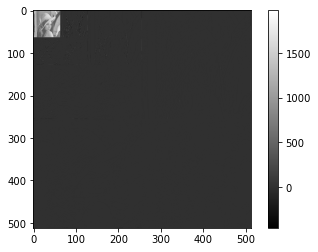

In [13]:
# Rangement des coefficients de décomposition dans un tableau
coeffs_list = pywt.coeffs_to_array(coeffs)[0]

# Visualisation 
plt.imshow(coeffs_list, cmap="gray")
plt.colorbar()

<h3 style="color: navy bleu"> A.2.3.Visualisation des sous bandes 

<ipython-input-14-e86a31295642>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, M/2, i+1)


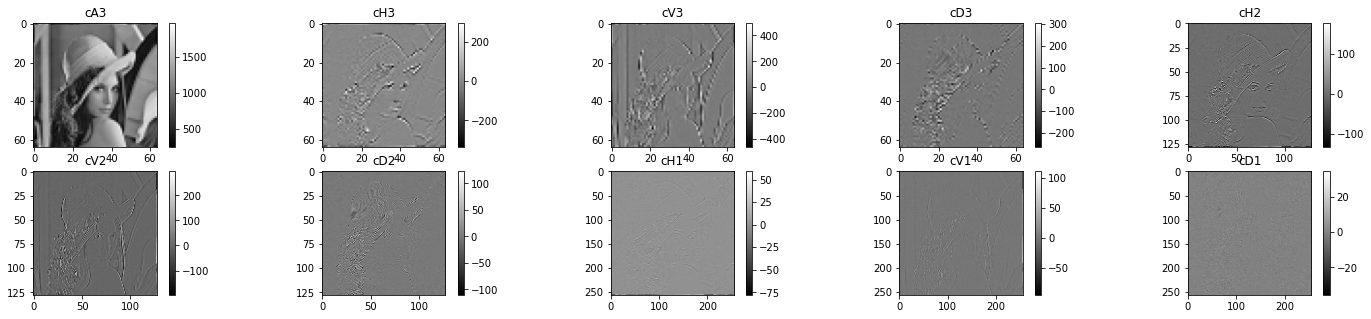

In [14]:
cA3, (cH3, cV3, cD3),(cH2, cV2, cD2),(cH1, cV1, cD1) = coeffs
list_ss_bande = [cA3, cH3, cV3, cD3, cH2, cV2, cD2, cH1, cV1, cD1]
labels_ss_bande = ['cA3', 'cH3', 'cV3', 'cD3', 'cH2', 'cV2', 'cD2', 'cH1', 'cV1', 'cD1']
K = len(list_ss_bande)
M = len(labels_ss_bande)

plt.figure(figsize=(25,5))
for i in range(K):
    plt.subplot(2, M/2, i+1)
    plt.imshow(list_ss_bande[i], cmap="gray")
    plt.colorbar()
    plt.title(f'{labels_ss_bande[i]}')

<h3 style="color: navy bleu"> A.3. Inverse de l'analyse multirésolution 2D 

Maintenant, on cherche à reconstruire l'image de Lena à l'aide de la commande <i>waverec2</i> à partir des coefficients de décomposition obtenus précédemment. <br />

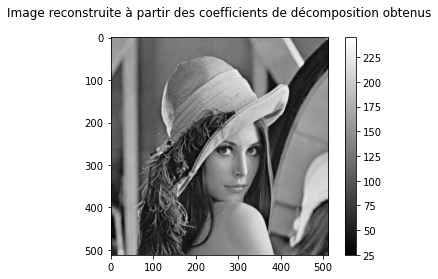

SNR =  303.7217076283763
PSNR =  309.3788401355137


In [15]:
img_reconst = pywt.waverec2(coeffs, wavelet = 'db2', mode='periodization')
plt.imshow(img_reconst, cmap="gray")
plt.colorbar()
plt.title('Image reconstruite à partir des coefficients de décomposition obtenus\n')
plt.show()

print("SNR = ", snr(img_reconst, y))
print("PSNR = ", psnr(img_reconst, y))

On a obtenu un SNR et un PSNR élevés, celà signifie que l'image a été bien restaurée. 

<h3 style="color: navy bleu"> B. Minimisation $\ell_2$ sur une base d'ondelettes

On souhaite à nouveau procéder à la déconvolution selon le modèle
$$
  z=(h\star y) + b = K_{h}(y) + b
$$

On cherche une solution à la synthèse i.e. 
$\widetilde{y}=F^{-1}\widetilde{x}$ où  $ \widetilde{x}$ minimise 
$$\underset{x \in \mathbb{R}^{N_1 \times N_2}}{\text{min}} \tfrac{1}{2} \|z-K_h(F^{-1}x)\|^2_2 + \lambda \|x\|^2_2.
$$

Ceci est un cas particulier du problème suivant qui consiste à minimiser
$$
\underset{x \in \mathbb{R}^{N_1 \times N_2}}{\text{min}} \{G(x)=\tfrac{1}{2} \|z-Ax\|^2_2 + \lambda \|x\|^2_2\}
$$
où $A$ est un opérateur linéaire borné, $\lambda>0$ est appelé paramètre de régularisation.

L'algorithme de descente de gradient (<em>Gradient descent Algorithm</em>) peut être utilisé pour minimiser l'équation précédente.
Il  est donné par
$$\left\{
  \begin{array}{rl}
    x^0 & \in\mathbb{R}^{N_1 \times N_2} \\
   x^{k+1}  &=x^k - \gamma^k \nabla G(x^k) 
  \end{array}
\right.
$$
où $\nabla G(x^k)$ est le gradient de $G$ par rapport à $x$ en $x^k$. Cet algorithme converge lorsque $0<\gamma_k<2/\beta$ où $\beta$ est la constante de Lipschitz de $\nabla G$.

<h3 style="color: navy bleu"> B.1. Calcul du gradient et du pas de descente

#### Partie 1 

1. L'algorithme de descente de gradient requiert le calcul du gradient de la fonction à minimiser

Soit $h \in \mathbb{R}^{N_1 \times N_2}$ 

On a 

$
\begin{array}{lll}
G(x+h) - G(x) & = & \tfrac{1}{2} \|z-A(x+h)\|^2_2 + \lambda \|x+h\|^2_2 - \tfrac{1}{2} \|z-Ax\|^2_2 - \lambda \|x\|^2_2 \\
              & = & \tfrac{1}{2} \|z-Ax -Ah\|^2_2 + \lambda <x+h,x+h> -G(x) \\ 
              & = & \tfrac{1}{2} \|z-Ax\|^2_2 + \frac{1}{2}\|Ah\|^2_2 - <z-Ax,Ah> + \lambda\|x\|^2_2 + \lambda <h,h> + 2 \lambda<x,h> - G(x) \\
              & = & \underbrace{\tfrac{1}{2} \|z-Ax\|^2_2 + \lambda\|x\|^2_2}_{G(x)} + \underbrace{\frac{1}{2}\|Ah\|^2_2 +  \lambda \|h\|^2}_{o(h)} - <z-Ax,Ah> +2 \lambda<x,h> - G(x)\\ 
              & = & o(h) - <A^*z -A^*Ax, A^*Ah> + 2 \lambda<x,h> \\
              & = & o(h) + <A^*(Ax-z)+2 \lambda x, h> \\
              & = & o(h) + <\nabla G(x),h>
\end{array}
$

Donc $\nabla G(x)=A^*(Ax-z)+2\lambda x$

2. Calculons la constante de Lipschitz :  

On a $\nabla G(x)=A^*(Ax-z)+2\lambda x$

$\nabla G(x)$ est $\beta$ lipschitzienne s'il existe $\beta > 0$ tel que $\|\nabla G(x) - \nabla G(y)\| \leq \beta \|x - y\| $ pour tout x,y 


$
\begin{array}{lll}
\|\nabla G(x) - \nabla G(y)\|& = & \|A^*(Ax-z) + 2\lambda x -  A^*(Ay-z) - 2\lambda y\| \\ 
                             & = & \|A^*Ax - A^*z + 2\lambda x - A^*Ay + A^*z - 2 \lambda y\| \\ 
                             & = & \|A^*A(x-y) + 2 \lambda (x-y)\| \\
                             & = & \|(A^*A +2 \lambda )(x-y)\| \\
                             &\leq& \|A^*A + 2 \lambda \| \|x-y\| \\
                             &\leq& (\|A^*A\| + 2 \lambda)  \|(x-y)\|
\end{array}
$

On a donc $\beta=\|A^*A\|+2 \lambda $

3. Intervalle des valeurs possibles : 

On a  $\beta=\|A^*A\|+2 \lambda $ et $0 <\gamma_k < \frac{2}{\beta}$

Donc $0 <\gamma_k < \frac{2}{\|A^*A\|+2 \lambda }$ pour tout k.

#### Partie 2 

Dans le cas particulier du problème
$$
\underset{x \in \mathbb{R}^{N_1 \times N_2}}{\text{min}} \tfrac{1}{2} \|z-K_h(F^{-1}x)\|^2_2 + \lambda \|x\|^2_2
,$$ on note que
que l'adjoint de $K_h\ \circ \ F^{-1}$ est $ F\ \circ \ K_{h^{1}} $ où
$$K_{h^{1}}(x) = h^{1}\star x\quad \text{ avec } \quad \widehat{ h^{1}}(w) =\overline{\widehat{ h}(w)}\quad\forall w. $$
L'algorithme de descente de gradient s'écrit alors dans ce cas :
$$\left\{
  \begin{array}{rl}
    x^0 & \in\mathbb{R}^{N_1 \times N_2} \\
   x^{k+1}  &= (1- 2 \lambda\gamma_k)x^k + \gamma_k \left( F\ \circ \ K_{h^{1}}(z-K_h\ \circ \ F^{-1}(x^k))\right)
  \end{array}
\right.
$$
et il permet de trouver les coefficients en ondelettes $\widetilde{x}$.

<h3 style="color: navy bleu"> B.2. Constante de Lipschitz pour la déconvolution

Sachant que $||K_h\ \circ \  F^{-1}||\leq 1$ lorsque $h$ vérifie  $h_n\geq 0\ \forall\ n$ et $\sum_n h_n \leq1$, expliciter la constante de Lipschitz $\beta$ dans le cas particulier où $A=K_h \circ F^{-1}$. Montrons que $\beta \leq 1 + 2 \lambda$.

#### Démonstration 

Soit $A = K_h \circ F^{-1}$ tq $\|K_h \circ F^{-1} \| \leq 1$ et $\beta=\|A^*A\|+2 \lambda $ 

Donc
$$
\begin{array}{llll}
\beta & = & \|A^*A\|+2 \lambda & \leq \|A^*\| \|A\| + 2 \lambda \\
      &   &                    & \leq 1 + 2 \lambda \quad car \quad \|A\| \leq 1 \quad et \quad \|A^*\| \leq 1
\end{array}
$$

On obtient $0 <\gamma_k < \frac{2}{1 + 2 \lambda }$

L'intervalle du pas de descente dans ce cas est : $\left]0, \frac{2}{1 + 2 \lambda }\right[$

<h3 style="color: navy bleu"> B.3. Déconvolution par descente de gradient

<ol>
<li> La fonction algograd prend en entrée l'image dégradée $z$, le filtre de dégradation $h$, le paramètre de régularisation $\lambda$, le nombre d'itération $N$ et le pas de l'algorithme $\gamma$ et qui donne en retour l'image restaurée par l'algorithme de gradient en effectuant $K$ itérations.

Les opérations clés sont :
	<ol>
		<li>Application de la transformée en ondelettes $F$ (wavedec2);</li>
		<li>Application de l'opérateur $K_h$ : produit terme à terme en Fourier (réponse fréquentielle $\widehat{h}$);</li>
		<li>Application l'adjoint de l'opérateur $K_{h^{1}}$ : produit terme à terme en Fourier avec le complexe conjugué (conj) de la réponse fréquentielle ${\widehat{h}}$.</li>
		<li>Application de la transformée en ondelettes inverse $F^{-1}$ (waverec2).</li>
        <li>Pour la gestion des coefficients d'ondelettes, on pourra s'appuyer sur les fonctions <i>coeffs_to_array</i> et <i>array_to_coeffs</i> de PyWavelets.</li>
	</ol></li>
</ol>

<h3 style="color: navy bleu"> B.3.1 Création de la fonction "algograd"

In [16]:
def algograd(z,h,l,K,gamma):
    """
    z : observations
    h : noyau de convolution
    l : paramètre de régularisation 
    gamma : pas de descente
    K : nombre d'itération
    
    """
    resNorm = np.zeros((K,1))
    hfft = np.fft.fft2(h)
    hfftConj = np.conj(hfft)
    #initialisation
    coeffs = pywt.wavedec2(z, 'db2',mode='periodization',level=3)
    x, coeff_slices = pywt.coeffs_to_array(coeffs)
    #Boucle
    for i in np.arange(0,K,1):
        # Transformee ondelette inverse (opération D.)
        y = pywt.waverec2(coeffs, 'db2',mode='periodization')
        # Application Kh et calcul du residu (opération B.)
        y = z - np.real(np.fft.ifft2(hfft*np.fft.fft2(y)))
        # Application de Kh1 (opération C.)
        y = np.real(np.fft.ifft2(hfftConj*np.fft.fft2(y)))
        # Mise à jour des coefficients (opération A.)
        coeffs_fid = pywt.wavedec2(y, 'db2',mode='periodization',level=3)
        xtmp_fid, coeff_slices_fid = pywt.coeffs_to_array(coeffs_fid)
        xtmp_reg, coeff_slices_reg = pywt.coeffs_to_array(coeffs)
        # Calcul du gradient
        grad = -xtmp_fid + 2*l*xtmp_reg
        # Descente de gradient
        xplus = xtmp_reg - gamma * grad
        coeffs = pywt.array_to_coeffs(xplus, coeff_slices_fid,output_format='wavedec2')
        # Calcul de la norme residuelle
        resNorm[i] = np.sum((x-xplus)**2)
        x=xplus  
    #Affichage de la courbe de convergence    
    y = pywt.waverec2(coeffs, 'db2',mode='periodization')
    # plt.figure(50)
    plt.semilogy(resNorm, label = f'lambda = {str(l)}')
    # plt.title('||x^{k+1} - x^k||')    
    # plt.show() 
    return y

<h3 style="color: navy bleu"> B.3.2 Application des deux algorithme et comparaison 

Maintenant on applique l'algorithme de descente de gradient pour restaurer l'image dégradée avec différentes valeurs de $\lambda$. On testera en priorité $\lambda=[0.001,0.01,0.1]$.
Note: il faut veiller à faire suffisamment d'itérations ($N$ grand) pour arriver à convergence. Pour le vérifier, on peut ajouter une figure dans algograd traçant $||x^{k+1} - x^{k}||$ en fonction de $k$.

Ensuite, nous allons Comparer qualitativement (sur des portions d'images par exemple) et quantitativement (SNR, PSNR) le meilleur résultat obtenu avec l'algorithme de Tikhonov et le meilleur résultat obtenu ici.

#### 1. Application de la fonction "algograd"

[]

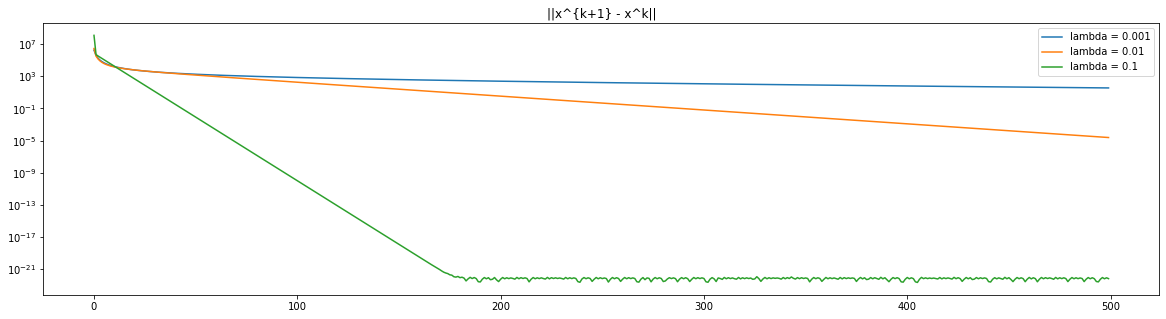

In [27]:
# Image dégradée
h = gaussian(n1,3)
sigma2 = 100
z = degrad_imag(y, h, sigma2, "gaussien")
K = 500

# Définition des valeurs de lambda sous forme d'une liste 
l = [0.001,0.01,0.1]

# Image dégradée
h = gaussian(n1,3)
sigma2 = 100
z = degrad_imag(y,h,sigma2,"gaussien")
K = 500

# Définition des valeurs de lambda sous forme d'une liste 
l = [0.001,0.01,0.1]

y_prime_list = []

plt.figure(figsize=(20,5))
for i in range(len(l)):
    gamma = 1/(1 + 2*l[i])
    y_prime_list.append(np.real(algograd(z, h,l[i], K,gamma)))

plt.title('||x^{k+1} - x^k||') 
plt.legend()
plt.plot()

SNR(y,y_prime) avec lambda de 0.001 : 16.302671798191497
PSNR(y,y_prime) avec lambda de 0.001: 21.91602424136072

SNR(y,y_prime) avec lambda de 0.01 : 20.58861241562173
PSNR(y,y_prime) avec lambda de 0.01: 26.443187914627124

SNR(y,y_prime) avec lambda de 0.1 : 12.661934946807714
PSNR(y,y_prime) avec lambda de 0.1: 19.969534188022784



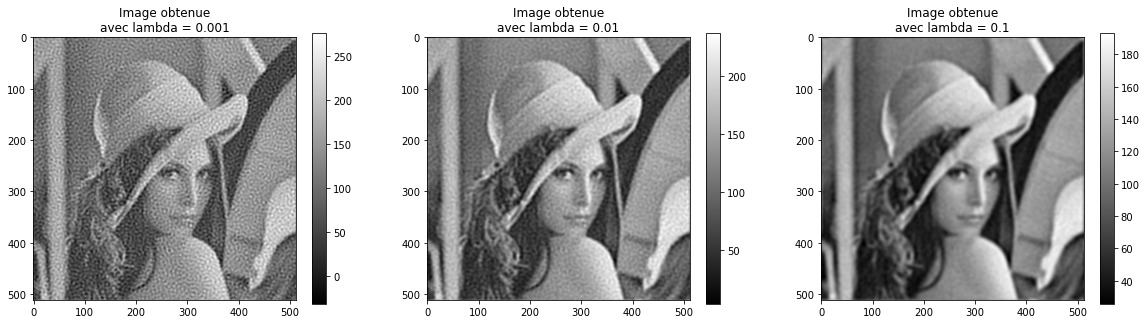

In [28]:
plt.figure(figsize=(20,5))
for i in range(len(l)):
    plt.subplot(1, len(l), i+1)
    plt.imshow(np.array(y_prime_list[i]), cmap="gray")
    plt.colorbar()
    plt.title(f'Image obtenue\navec lambda = {l[i]}')
    print(f'SNR(y,y_prime) avec lambda de {l[i]} : {snr(y,y_prime_list[i])}')
    print(f'PSNR(y,y_prime) avec lambda de {l[i]}: {psnr(y,y_prime_list[i])}\n')

#### 2.  Application de l'algorithme Tikhonov 

In [29]:
def tikhonov(z,h,l):
    hfft = np.fft.fft2(h)
    hfftConj = np.conj(hfft)
    zfft = np.fft.fft2(z)

    y_tikhonov = np.real(np.fft.ifft2( hfftConj*zfft / (hfft*hfftConj + l) ))
    return y_tikhonov

SNR(y_tikhonov,y) avec lambda de 0.001 : 5.584328145417601
PSNR(y_tikhonov,y) avec lambda de 0.001: 9.405079881048712

SNR(y_tikhonov,y) avec lambda de 0.01 : 12.959793199497533
PSNR(y_tikhonov,y) avec lambda de 0.01: 18.278968343347906

SNR(y_tikhonov,y) avec lambda de 0.1 : 17.892499256388593
PSNR(y_tikhonov,y) avec lambda de 0.1: 24.302792473565024



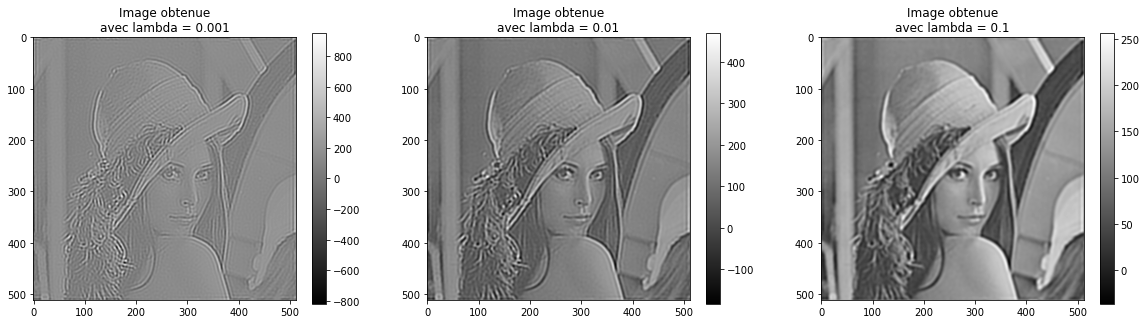

In [30]:
# Définition des valeurs de lambda sous forme d'une liste 
lambda_vect = [0.001,0.01,0.1]

# taille de la figure 
plt.figure(figsize=(20,5))

# Faire une boucle pour afficher chaque image associée à chaque lambda 
for i in range(len(lambda_vect)) : 

    y_tikhonov = np.real(tikhonov(y, h, lambda_vect[i]))
    # Pour afficher les images sur une seule ligne 
    plt.subplot(1, 3, i+1)
    plt.imshow(y_tikhonov, cmap="gray")
    plt.colorbar()
    plt.title(f'Image obtenue\navec lambda = {lambda_vect[i]}')

    print(f'SNR(y_tikhonov,y) avec lambda de {lambda_vect[i]} : {snr(y,y_tikhonov)}')
    print(f'PSNR(y_tikhonov,y) avec lambda de {lambda_vect[i]}: {psnr(y,y_tikhonov)}\n')

#### 3. Comparaison entre les deux algorithmes 

$$\begin{array}{|c|c|c|c|}
\hline
& & ALGOGRAD & TIKHONOV \\
\hline
\lambda = 0.001 & \begin{array}{c}SNR\\PSNR \end{array} & \begin{array}{c}16.23\\21.84 \end{array} & \begin{array}{c}5.58\\9.40 \end{array}\\
\hline
\lambda = 0.01 & \begin{array}{c}SNR\\PSNR \end{array} & \begin{array}{c}20.56\\26.41 \end{array} & \begin{array}{c}12.96\\18.28 \end{array} \\
\hline
\lambda = 0.1 & \begin{array}{c}SNR\\PSNR \end{array} & \begin{array}{c}12.66\\19.97 \end{array} & \begin{array}{c}17.89\\24.30 \end{array} \\
\hline
\end{array}$$

D'après les images obtenues (qualitativement), les résultats montrent qu'avec l'algorithme de descente de gradient, l'image restaurée avec $\lambda = 0.01$ est la moins bruitée parmi les 3 images. Celà est confirmé quantativement avec des SNR et PSNR les plus élevés (20.56 et 26.41). 

En revanche, avec l'algorithme de Tikhonov, on a une image moins bruitée avec $\lambda = 0.1$ où les SNR et PSNR valent environ 17.89 et 24.30 respectivement. 

Concernant le graphe des convergences des algorithmes de decentes de gradient avec les différents paramètres de $\lambda$, on remarque que l'algorithme ayant $\lambda = 0.1$ converge plus vite par rapport aux autres. On en déduit donc que plus  $\lambda$ est grand, plus la converge est rapide mais l'image restaurée n'est pas forcément la moins bruitée.

<h3 style="color: navy bleu"> C. Minimisation $\ell_1$ sur une base d'ondelettes

On souhaite à nouveau procéder à la déconvolution selon le modèle
$$
  z=(h\star y) + b = K_{h}(y) + b
$$

On cherche (comme pour le cas du débruitage sur la base d'ondelettes) une solution à la synthèse i.e. 
$\widetilde{y}=F^{-1}\widetilde{x}$ où  $ \widetilde{x}$ minimise 
$$\underset{x \in \mathbb{R}^{N_1 \times N_2}}{\text{min}} \tfrac{1}{2} \|z-K_h(F^{-1}x)\|^2_2 + \lambda \|x\|_1.
$$

Ceci est un cas particulier du problème suivant qui consiste à minimiser
$$
\underset{x \in \mathbb{R}^{N_1 \times N_2}}{\text{min}} \{L(x)=\tfrac{1}{2} \|z-Ax\|^2_2 + \lambda \|x\|_1\}
$$
où $A$ est un opérateur linéaire borné, $\lambda>0$ est appelé paramètre de régularisation.

L'algorithme de seuillage itératif appelé ISTA (<em>Iterative Soft Thresholding Algorithm</em>) est un (parmi les nombreux) algorithme qui permet de minimiser l'équation précédente.
Il  est donné par
$$\left\{
  \begin{array}{rl}
    x^0 & \in\mathbb{R}^{N_1 \times N_2} \\
   x^{k+1}  &=\text{Soft}_{\lambda}\left(x^k+A^*(z-Ax^k)\right)  
  \end{array}
\right.
$$
où $A^*$ est l'opérateur adjoint de $A$ et où $\text{Soft}_{\lambda}$ agit ici sur chaque coordonnée de $x$ dans $\mathbb{R}^{N_1 \times N_2}$ indépendamment. Il est défini par
$$
\text{Soft}_{\lambda}(x)=\begin{cases}x-\lambda & \text{si } x\geq\lambda \\
x+\lambda & \text{si } x\leq -\lambda \\
0 & \text{sinon.} \end{cases}
$$

<h3 style="color: navy bleu"> C.1. Origine de ISTA

#### Partie 1 

Dans cet exercice, on souhaite montrer que ISTA peut être vu comme un algorithme de Majoration-Minimisation. On suppose ici que $||A||\leq 1$.
On pose 
$$
H(x,x')=\tfrac{1}{2} \|z-Ax\|^2_2 + \lambda \|x\|_1 + \tfrac{1}{2}||x-x'||^2 -\tfrac{1}{2}||A(x-x')||^2 .
$$
<ol>
<li> Montrer que $H(.,x')$ est une majorante de $L$ qui coïncide en $x'$ (i.e. que pour tout $x$, $H(x,x') \geq L(x)$ et que $H(x',x') = L(x')$). </li>
<li> Montrer que 
$$
H(x,x')=\tfrac{1}{2} ||x||^2-\langle x, x'+A^*(z-Ax') \rangle+ \lambda \|x\|_1 + \tfrac{1}{2}||z||^2 + \tfrac{1}{2}||x'||^2 -\tfrac{1}{2}||Ax'||^2 
$$ </li>
<li> En déduire 
$$
H(x,x')=\tfrac{1}{2} ||x - (x'+A^*(z-Ax')) ||^2 + \lambda \|x\|_1 + ||z||^2 + \tfrac{1}{2}||x'||^2 -\tfrac{1}{2}||Ax'||^2 -\tfrac{1}{2}||x'+A^*(z-Ax') ||^2
$$</li>
<li> Prouver alors que pour $x'$ fixé :
$$
\widetilde x =\text{argmin}_x H(x,x')\Leftrightarrow \widetilde x 
=\text{argmin}_x\tfrac{1}{2} ||x - (x'+A^*(z-Ax')) ||^2 + \lambda \|x\|_1 
$$</li>
<li>Déduire pour $x'$ fixé :
$$
\widetilde x =\text{argmin}_x H(x,x')\Leftrightarrow \widetilde x 
=\text{Soft}_{\lambda}\left(x'+A^*(z-Ax')\right)
$$ </li>
<li> Conclure. </li>
</ol>
</em>



#### Démonstration 

1. Montrons que $H(x,x')$ est une majorante de $L$ 

$L(x) = \frac{1}{2} ||z-Ax||^2_2 + \lambda||x||_1$

$H(x,x') = \underbrace{\frac{1}{2} * ||z - Ax||^2_2 + \lambda||x||_1}_{f_1} + \underbrace{\frac{1}{2}||x-x'||^2 - \frac{1}{2}||A(x-x')||^2}_{f_2}$


$
\begin{array}{llll}
f_2 & = & \frac{1}{2}||x-x'||^2 - \frac{1}{2}||A(x-x')||^2 & \\
& = & \frac{1}{2}||x-x'||^2 - \frac{1}{2}||A||^2||x-x'||^2 & \\
& \geq & \frac{1}{2}||x-x'|| - \frac{1}{2}||x-x'||^2 & car \quad ||A|| \leq 1 \quad donc \quad -||A|| \geq -1\\
& \geq & 0 &
\end{array}
$

$H(x,x') = f_1 + f_2$ or $f2 \geq 0$ donc $H(x,x') \geq 0$

Ce qui implique que $H(x,x') \geq f_1 = L(x)$

$H(x', x') = \frac{1}{2} ||z - Ax'||^2_2 + \lambda||x'||_2^2 + \frac{1}{2} \underbrace{||x'-x'||^2}_{= 0} - \frac{1}{2}||A\underbrace{(x'-x')}_{= 0}||^2 = f_1 = L(x')$

Donc $H(x,x')$ coincide avec $L(x)$ en x'.

2. Montrons l'égalité ded deux formules 

Soit 
$$H(x,x')= \underbrace{\tfrac{1}{2} \|z-Ax\|^2_2}_A + \lambda \|x\|_1 + \underbrace{\tfrac{1}{2}||x-x'||^2}_B  - \underbrace{\tfrac{1}{2}||A(x-x')||^2}_C$$

$
\begin{array}{lll}
A & = & \tfrac{1}{2} \langle z-Ax, z-Ax \rangle \\
  & = & \langle z,z \rangle - \langle Ax,z \rangle - \langle z,Ax \rangle + \langle Ax, Ax \rangle \\
  & = & \tfrac{1}{2}||z||^2 + \tfrac{1}{2}||Ax||^2 - \langle Ax, z\rangle \\
  & = & \tfrac{1}{2}||z||^2 + \tfrac{1}{2}||Ax||^2 - \langle x, A^*z\rangle
\end{array}
$

$
\begin{array}{lll}
B & = & \tfrac{1}{2} \langle x-x', x-x' \rangle \\
  & = & \tfrac{1}{2} \langle x,x \rangle - \langle x',x \rangle + \tfrac{1}{2} \langle x',x' \rangle \\
  & = & \tfrac{1}{2}||x||^2 + \tfrac{1}{2}||x'||^2 - \langle x', x \rangle
\end{array}
$

$
\begin{array}{lll}
C & = & \tfrac{1}{2} \langle Ax-Ax', Ax-Ax' \rangle \\
  & = & \tfrac{1}{2}\langle Ax, Ax \rangle - \tfrac{1}{2} \times 2 \langle Ax',Ax \rangle + \tfrac{1}{2} \langle Ax', Ax' \rangle \\
  & = & \tfrac{1}{2}||Ax||^2 - \langle Ax',Ax \rangle + \tfrac{1}{2}||Ax'||^2
\end{array}
$

$
\begin{array}{lll}
H(x,x') & = & \tfrac{1}{2}||z||^2 + \tfrac{1}{2}||Ax||^2 - \langle x,A^*z \rangle + \lambda||x||_1 + \tfrac{1}{2}||x||^2 + \tfrac{1}{2}||x'||^2 - \langle x',x \rangle - \tfrac{1}{2}||Ax||^2 + \langle Ax',Ax \rangle - \tfrac{1}{2}||Ax'||^2 \\
        & = & \tfrac{1}{2}||z||^2 + \tfrac{1}{2}||x||^2 +\lambda||x||_1 - \tfrac{1}{2}||Ax'||^2 + \tfrac{1}{2}||x'||^2 - \langle x, A^*z \rangle - \langle x',x \rangle + \langle Ax',Ax \rangle \\
        & = & \tfrac{1}{2}||z||^2 + \tfrac{1}{2}||x||^2 +\lambda||x||_1 - \tfrac{1}{2}||Ax'||^2 + \tfrac{1}{2}||x'||^2  - \langle x, A^*z + x' + A^*Ax' \rangle \\
        & = & \tfrac{1}{2} ||x||^2-\langle x, x'+A^*(z-Ax') \rangle+ \lambda \|x\|_1 + \tfrac{1}{2}||z||^2 + \tfrac{1}{2}||x'||^2 -\tfrac{1}{2}||Ax'||^2 .....(*1)
\end{array}
$

3. Montrons que : 
    $$
H(x,x')=\underbrace{\tfrac{1}{2} ||x - (x'+A^*(z-Ax')) ||^2}_A + \lambda \|x\|_1 + ||z||^2 + \tfrac{1}{2}||x'||^2 -\tfrac{1}{2}||Ax'||^2 -\tfrac{1}{2}||x'+A^*(z-Ax') ||^2
$$

On a 
$$
\begin{array}{ll}
&A = \tfrac{1}{2}\|x\|^2 + \tfrac{1}{2}\|x' + A^*(z - Ax')\|^2 -  \langle x, x' + A^*(z - Ax') \rangle \\
Donc  &- \langle x, x' + A^* (z - Ax)\rangle = A-\tfrac{1}{2}\|x\|^2 - \tfrac{1}{2}\|x' + A^*(z - Ax')\|^2 .....(*2)
\end{array}
$$

Maintenant, on remplace $(*2)$ dans $(*1)$, on trouve : 

$H(x,x')=\tfrac{1}{2} ||x||^2 + \tfrac{1}{2} ||x - (x'+A^*(z-Ax')) ||^2- \tfrac{1}{2}\|x\|^2 - \tfrac{1}{2}\|x' + A^*(z - Ax')\|^2 + \lambda \|x\|_1 + \tfrac{1}{2}||z||^2 + \tfrac{1}{2}||x'||^2 -\tfrac{1}{2}||Ax'||^2$

Donc 
$H(x,x')= \tfrac{1}{2} ||x - (x'+A^*(z-Ax')) ||^2 + \lambda \|x\|_1 + \tfrac{1}{2}||z||^2 + \tfrac{1}{2}||x'||^2 -\tfrac{1}{2}||Ax'||^2 - \tfrac{1}{2}\|x' + A^*(z - Ax')\|^2 $ 


4. Montrons que pour x fixé : $$
\widetilde x =\text{argmin}_x H(x,x')\Leftrightarrow \widetilde x 
=\text{argmin}_x\tfrac{1}{2} ||x - (x'+A^*(z-Ax')) ||^2 + \lambda \|x\|_1 
$$

Soit $x'$ fixé, on a :

$$
\tilde{x} = \underset{x}{argmin}H(x,x') = \underset{x}{argmin}(\tfrac{1}{2}\| x - (x' + A^*(z - Ax') \|^2 + \lambda \| x \|_1 + \underbrace{ \| z \|^2_2 + \tfrac{1}{2}\| x' \|^2 - \tfrac{1}{2}\| Ax' \|^2 - \tfrac{1}{2}\| x' + A^*(z - Ax') \|^2}_B ) 
$$

On remarque que la partie B ne dépend pas de $x$ donc on peut la considérer comme constante dans notre cas. 

D'où
$$
    \tilde{x} = \underset{x}{argmin}(\tfrac{1}{2}\| x - (x' + A^*(z - Ax')) \|^2 + \lambda \| x \|_1)
$$

5. 

Soit $x'$ fixé, on a $$
    \tilde{x} = \underset{x}{argmin}( \underbrace{\tfrac{1}{2}\| x - \underbrace{ (x' + A^*(z - Ax'))}_{\alpha}\|^2 + \lambda \| x \|_1)}_{f}
$$

Considérons $f(x) = \tfrac{1}{2}\| x - \alpha \|^2 + + \lambda \| x \|_1$

Alors $\nabla f(x) = x - \alpha + \lambda sign(x_i) \quad \forall i \in N_1 \cup N_2 $ 


$\nabla f(x) = 0 \Longleftrightarrow \tilde{x}- \alpha + \lambda sign(\tilde{x})= 0 \Longleftrightarrow \tilde{x} = \alpha - \lambda sign(\tilde{x}) = Soft_\lambda (\alpha) = Soft_\lambda (x' + A^*(z - Ax'))$


6. $H(x,x')$ atteint un minimum en $ \tilde{x}= Soft_\lambda (x' + A^*(z - Ax'))$.

#### Partie 2 

Dans le cas particulier du problème
$$
\underset{x \in \mathbb{R}^{N_1 \times N_2}}{\text{min}} \tfrac{1}{2} \|z-K_h(F^{-1}x)\|^2_2 + \lambda \|x\|_1
,$$ on note que
que l'adjoint de $K_h\ \circ \ F^{-1}$ est $ F\ \circ \ K_{h^{1}} $ où
$$K_{h^{1}}(x) = h^{1}\star x\quad \text{ avec } \quad \widehat{ h^{1}}(w) =\overline{\widehat{ h}(w)}\quad\forall w. $$
ISTA s'écrit alors dans ce cas :
$$\left\{
  \begin{array}{rl}
    x^0 & \in\mathbb{R}^{N_1 \times N_2} \\
   x^{k+1}  &=\text{Soft}_{\lambda}\left(x^k+F\ \circ \ K_{h^{1}}(z-K_h\ \circ \ F^{-1}(x^k))\right)
  \end{array}
\right.
$$
et il permet de trouver les coefficients en ondelettes $\widetilde{x}$.
(On note que l'on a bien $||K_h\ \circ \  F^{-1}||\leq 1$ lorsque $h$ vérifie  $h_n\geq 0\ \forall\ n$ et $\sum_n h_n \leq1$).

<h3 style="color: navy bleu"> C.2. Déconvolution par seuillage itérati

<li>Ecrire une fonction ista qui prend en entrée l'image dégradée $z$, le filtre de dégradation $h$ et le paramètre de régularisation $\lambda$ et le nombre d'itération $N$ et qui donne en retour l'image restaurée par ISTA en effectuant $N$ itérations.

Les opérations clés sont :
	<ol>
		<li>Application de la transformée en ondelettes $F$ (wavedec2);</li>
		<li>Application de l'opérateur $K_h$ : produit terme à terme en Fourier (réponse fréquentielle $\widehat{h}$);</li>
		<li>Application l'adjoint de l'opérateur $K_{h^{1}}$ : produit terme à terme en Fourier avec le complexe conjugué (conj) de la réponse fréquentielle ${\widehat{h}}$.</li>
		<li>Application de la transformée en ondelettes inverse $F^{-1}$ (waverec2).</li>
		<li>Le seuillage doux (on pourra coder soit-même la fonction ou utiliser la fonction <i>threshold</i> de PyWavelets). </li>
	</ol></li>
<li>Appliquer l'algorithme ISTA pour restaurer l'image dégradée de l'exercice 6 avec différentes valeurs de $\lambda$. On testera en priorité $\lambda=[0.1,1,10]$.<br />
Note: il faut veiller à faire suffisamment d'itérations ($N$ grand) pour arriver à convergence. Pour le vérifier, on peut ajouter une figure dans ISTA traçant $||x^{k+1} - x^{k}||$ en fonction de $k$.</li>
<li>Comparer qualitativement (sur des portions d'images par exemple) et quantitativement (SNR, PSNR) le meilleur résultat obtenu avec l'algorithme de Tikhonov, avec la descente de gradient et le meilleur résultat obtenu ici.
</li>
</ol>

<h3 style="color: navy bleu"> C.2.1. Création de la fonction "ista"

In [32]:
def ista(z,h,l,N):
    """
    z : observations
    h : noyau de convolution
    l : paramètre de régularisation 
    N : nombre d'itération
    
    """
  
    resNorm = np.zeros((N,1))
    hfft = np.fft.fft2(h)
    hfftConj = np.conj(hfft)
    #initialisation
    tmp = []
    coeffs = pywt.wavedec2(z, 'db2',mode='periodization',level= 3) #5
    x, coeff_slices = pywt.coeffs_to_array(coeffs)
    #Boucle
    for i in np.arange(0,N,1):
        # Transformee ondelette inverse (opération D.)
        y = pywt.waverec2(coeffs, 'db2',mode='periodization')
        
        # Application Kh et calcul du residu (opération B.)
        y = z - np.real(np.fft.ifft2(hfft*np.fft.fft2(y)))
        # Application de Kh1 (opération C.)
        y = np.real(np.fft.ifft2(hfftConj*np.fft.fft2(y)))
        # Mise à jour des coefficients (opération A.)
        coeffs_fid = pywt.wavedec2(y, 'db2',mode='periodization',level= 3)
        xtmp_fid, coeff_slices_fid = pywt.coeffs_to_array(coeffs_fid)
        tmp.append(pywt.threshold(x + xtmp_fid, l, 'soft'))
        #xtmp_reg, coeff_slices_reg = pywt.coeffs_to_array(coeffs)
        
        xplus = tmp[i]
        #xplus = xtmp_reg - gamma * grad
        coeffs = pywt.array_to_coeffs(xplus, coeff_slices_fid,output_format='wavedec2')
        # Calcul de la norme residuelle
        resNorm[i] = np.sum((x-xplus)**2)
        x=xplus  
    #Affichage de la courbe de convergence    
    y = pywt.waverec2(coeffs, 'db2',mode='periodization')
    # plt.figure(50)
    plt.semilogy(resNorm, label = f'lambda = {str(l)}')
    # plt.title('||x^{k+1} - x^k||')    
    # plt.show() 
    return y

<h3 style="color: navy bleu"> C.2.2 Application de l'algorithme ISTA 

[]

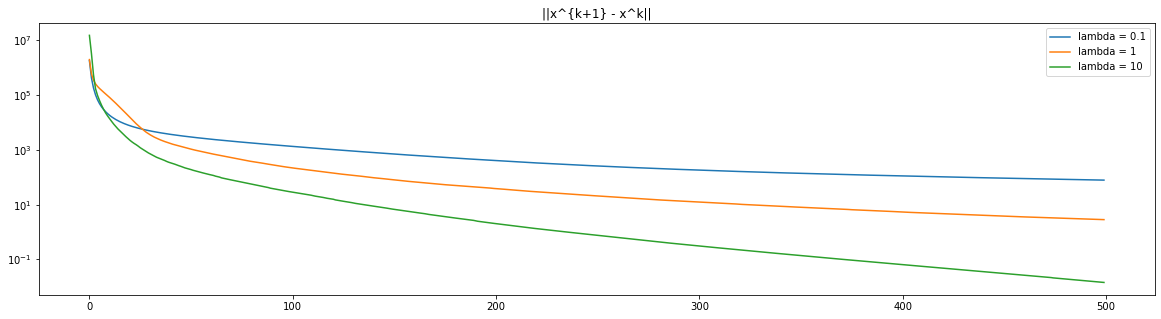

In [34]:
# Image dégradée
h = gaussian(n1,3)
sigma2 = 100
z = degrad_imag(y,h,sigma2,"gaussien")
N = 500

# Définition des valeurs de lambda sous forme d'une liste 
l = [0.1, 1, 10]

y_ista = []

plt.figure(figsize=(20,5))
for i in range(len(l)):
    gamma = 1/(1 + 2*l[i])
    y_ista.append(np.real(ista(z, h,l[i], N)))

plt.title('||x^{k+1} - x^k||') 
plt.legend()
plt.plot()

SNR(y,y_prime) avec lambda de 0.1 : 15.927278147684028
PSNR(y,y_prime) avec lambda de 0.1: 21.51133385605575

SNR(y,y_prime) avec lambda de 1 : 19.773690530266087
PSNR(y,y_prime) avec lambda de 1: 25.443421546647684

SNR(y,y_prime) avec lambda de 10 : 19.470660088930025
PSNR(y,y_prime) avec lambda de 10: 25.234875121504203



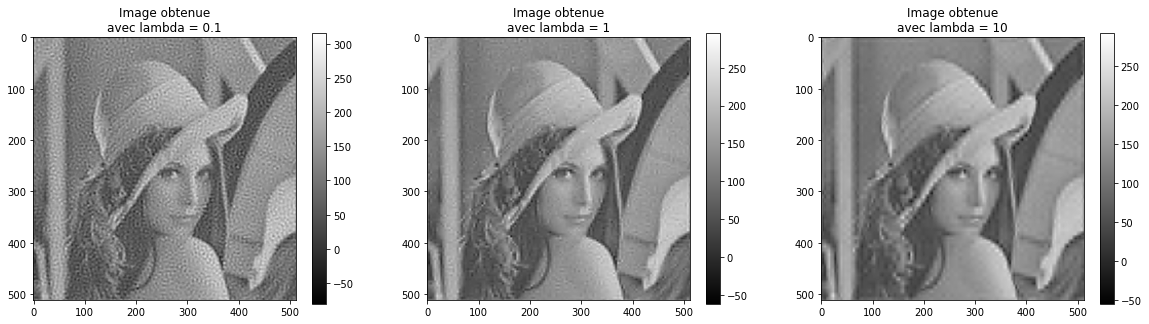

In [35]:
plt.figure(figsize=(20,5))
for i in range(len(l)):
    plt.subplot(1, len(l), i+1)
    # Pour afficher les images sur une seule ligne 
    plt.imshow(y_ista[i], cmap="gray")
    plt.colorbar()
    plt.title(f'Image obtenue\navec lambda = {l[i]}')
    print(f'SNR(y,y_prime) avec lambda de {l[i]} : {snr(y,y_ista[i])}')
    print(f'PSNR(y,y_prime) avec lambda de {l[i]}: {psnr(y,y_ista[i])}\n')

<h3 style="color: navy bleu"> C.2.3 Application de l'algorithme Tikhonov 

SNR(y_tikhonov,y) avec lambda de 0.1 : 17.892499256388593
PSNR(y_tikhonov,y) avec lambda de 0.1: 24.302792473565024

SNR(y_tikhonov,y) avec lambda de 1 : -0.15322760087172907
PSNR(y_tikhonov,y) avec lambda de 1: 11.57313201761111

SNR(y_tikhonov,y) avec lambda de 10 : -20.10163012397239
PSNR(y_tikhonov,y) avec lambda de 10: 6.471928876551773



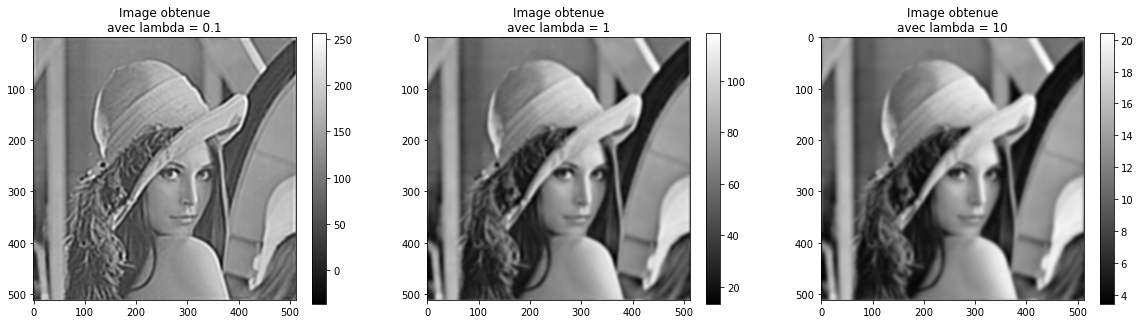

In [36]:
# Définition des valeurs de lambda sous forme d'une liste 
lambda_vect2 = [0.1, 1, 10]

# taille de la figure 
plt.figure(figsize=(20,5))

# Faire une boucle pour afficher chaque image associée à chaque lambda 
for i in range(len(lambda_vect2)) : 

    y_tikhonov = np.real(tikhonov(y, h, lambda_vect2[i]))
    # Pour afficher les images sur une seule ligne 
    plt.subplot(1, 3, i+1)
    plt.imshow(y_tikhonov, cmap="gray")
    plt.colorbar()
    plt.title(f'Image obtenue\navec lambda = {lambda_vect2[i]}')

    print(f'SNR(y_tikhonov,y) avec lambda de {lambda_vect2[i]} : {snr(y,y_tikhonov)}')
    print(f'PSNR(y_tikhonov,y) avec lambda de {lambda_vect2[i]}: {psnr(y,y_tikhonov)}\n')

$$\begin{array}{|c|c|c|c|}
\hline
& & ISTA & TIKHONOV \\
\hline
\lambda = 0.1 & \begin{array}{c}SNR\\PSNR \end{array} & \begin{array}{c}16.10\\21.69 \end{array} & \begin{array}{c}17.89\\24.30 \end{array}\\
\hline
\lambda = 1 & \begin{array}{c}SNR\\PSNR \end{array} & \begin{array}{c}19.85\\25.52 \end{array} & \begin{array}{c}-0.15\\11.57 \end{array} \\
\hline
\lambda = 10 & \begin{array}{c}SNR\\PSNR \end{array} & \begin{array}{c}19.66\\25.39 \end{array} & \begin{array}{c}-20.10\\6.47 \end{array} \\
\hline
\end{array}$$

D'après les résultats, on remarque qu'avec le graphique, l'algorithme ISTA qui converge le plus vite est celui qui a un $\lambda = 10$ donc plus le paramètre de régularisation est grand, plus l'algorithme converge rapidement. 

En se référant aux SNR et PSNR, on remarque que l'image la moins bruitée avec l'algorithme ISTA est celle qui a 1 comme valeur de $\lambda$ (SNR = 19.85 et PSNR = 25.52). En revanche, pour l'algorithme Tikhonov, l'image qui a été le mieux restaurée est celle qui a un $\lambda=0.1$ avec un SNR = 17.89 et PSNR = 24.30.


<h3 style="color: navy bleu"> Conclusion 



$$
\begin{array}{|c|c|c|c|c|}
    \hline
   Valeur & Critère& ALGOGRAD & TIKHONOV & ISTA\\
    \hline
    \lambda = 0.1 & \begin{array}{c}SNR\\PSNR \end{array} & \begin{array}{c}12.66\\19.97 \end{array} & \begin{array}{c}17.89\\24.30 \end{array} & \begin{array}{c}16.10\\21.69 \end{array}\\
    \hline
\end{array}
$$

Nous constatons que pour $\lambda = 0.1$ l'algorithme de Tikhonov donne un résultat plus satisfaisant. 